In [1]:
import time
import h5py as h5
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
tf.__version__

'2.0.0'

In [2]:
herwig = "GAN-data\events_anomalydetection_DelphesHerwig_qcd_features.h5"
pythiabg = "GAN-data\events_anomalydetection_DelphesPythia8_v2_qcd_features.h5"
pythiasig = "GAN-data\events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5"

datatypes = ["herwig", "pythiabg", "pythiasig"]
df = {}

df["herwig"] = pd.read_hdf(herwig)
print("Herwig shape: " + str(df["herwig"].shape))
print("Memory usage in GB:", round(sum(df["herwig"].memory_usage(deep=True)) / (1024**3), 3))

df["pythiabg"] = pd.read_hdf(pythiabg)
print("Pythia background shape: " + str(df["pythiabg"].shape))
print("Memory usage in GB:", round(sum(df["pythiabg"].memory_usage(deep=True)) / (1024**3), 3))

df["pythiasig"] = pd.read_hdf(pythiasig)
print("Pythia signal shape: " + str(df["pythiasig"].shape))
print("Memory usage in GB:", round(sum(df["pythiasig"].memory_usage(deep=True)) / (1024**3), 3))

Herwig shape: (999999, 14)
Memory usage in GB: 0.112
Pythia background shape: (999999, 14)
Memory usage in GB: 0.112
Pythia signal shape: (99999, 14)
Memory usage in GB: 0.011


In [3]:
#X = np.concatenate((df["pythiabg"], df["pythiasig"]))
#y = np.concatenate((np.zeros(df["pythiabg"].shape[0]), np.ones(df["pythiasig"].shape[0])))

X = np.array(df["pythiasig"])
y = np.ones(df["pythiasig"].shape[0])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [5]:
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(X_test).batch(BATCH_SIZE)

In [6]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(50, use_bias=False, input_shape=(14,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(50, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(50, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(14, use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 14)

    return model

In [7]:
generator = make_generator_model()

In [8]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(50, input_shape=(14,)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(50))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1))

    return model

In [9]:
discriminator = make_discriminator_model()

In [12]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                700       
_________________________________________________________________
batch_normalization (BatchNo (None, 50)                200       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2500      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2

In [13]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                750       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [10]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [11]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [12]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [13]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [14]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer, generator=generator, discriminator=discriminator)

In [15]:
EPOCHS = 200
noise_dim = 14

In [16]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [17]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

In [18]:
train(train_dataset, EPOCHS)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Time for epoch 1 is 4.298966646194458 sec
Time for epoch 2 is 1.1799991130828857 sec
Time for epoch 3 is 1.116997480392456 sec
Time for epoch 4 is 1.1109991073608398 sec
Time for epoch 5 is 1.0980010032653809 sec
Time for epoch 6 is 1.1490023136138916 sec
Time for epoch 7 is 1.125971794128418 sec
Time for epoch 8 is 1.0969972610473633 sec
Time for epoch 9 is 1.0949978828430176 sec
Time for epoch 10 is 1.0899982452392578 sec
Time for epoch 11 is 1.0790019035339355 sec
Time for epoch 12 is 1.0809988975524

In [19]:
fakedata = np.array(generator(tf.random.normal([10000, noise_dim]), training=False))

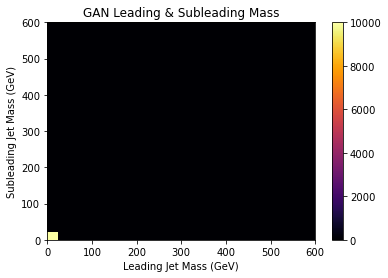

In [20]:
plt.title("GAN Leading & Subleading Mass")
plt.ylabel("Subleading Jet Mass (GeV)")
plt.xlabel("Leading Jet Mass (GeV)")
plt.hist2d(fakedata[:,3], fakedata[:,10], bins = 25, range = [[0,600],[0,600]], cmap = 'inferno')
plt.colorbar()
plt.show()

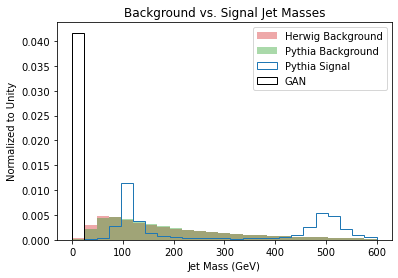

In [21]:
plt.title("Background vs. Signal Jet Masses")
plt.ylabel("Normalized to Unity")
plt.xlabel("Jet Mass (GeV)")
plt.hist(np.concatenate((df["herwig"]["mj1"], df["herwig"]["mj2"])), bins = 25, range = (0, 600), color = "tab:red", alpha = 0.4, label = "Herwig Background", density = True)
plt.hist(np.concatenate((df["pythiabg"]["mj1"], df["pythiabg"]["mj2"])), bins = 25, range = (0, 600), color = "tab:green", alpha = 0.4, label = "Pythia Background", density = True)
plt.hist(np.concatenate((df["pythiasig"]["mj1"], df["pythiasig"]["mj2"])), bins = 25, range = (0, 600), color = "tab:blue", histtype = "step", label = "Pythia Signal", density = True)
plt.hist(np.concatenate((fakedata[:,3], fakedata[:,10])), bins = 25, range = (0, 600), color = "black", histtype = "step", label = "GAN", density = True)
plt.legend()
plt.show()

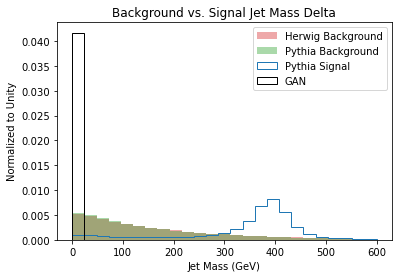

In [22]:
plt.title("Background vs. Signal Jet Mass Delta")
plt.ylabel("Normalized to Unity")
plt.xlabel("Jet Mass (GeV)")
plt.hist(np.abs(df["herwig"]["mj1"] - df["herwig"]["mj2"]), bins = 25, range = (0, 600), color = "tab:red", alpha = 0.4, label = "Herwig Background", density = True)
plt.hist(np.abs(df["pythiabg"]["mj1"] - df["pythiabg"]["mj2"]), bins = 25, range = (0, 600), color = "tab:green", alpha = 0.4, label = "Pythia Background", density = True)
plt.hist(np.abs(df["pythiasig"]["mj1"] - df["pythiasig"]["mj2"]), bins = 25, range = (0, 600), color = "tab:blue", histtype = "step", label = "Pythia Signal", density = True)
plt.hist(np.abs(fakedata[:,3] - fakedata[:,10]), bins = 25, range = (0, 600), color = "black", histtype = "step", label = "GAN", density = True)
plt.legend()
plt.show()

In [23]:
for datatype in datatypes:
    df[datatype]["ej1"] = np.sqrt(df[datatype]["mj1"]**2 + df[datatype]["pxj1"]**2 + df[datatype]["pyj1"]**2 + df[datatype]["pzj1"]**2)
    df[datatype]["ej2"] = np.sqrt(df[datatype]["mj2"]**2 + df[datatype]["pxj2"]**2 + df[datatype]["pyj2"]**2 + df[datatype]["pzj2"]**2)

In [24]:
ej1 = np.sqrt(fakedata[:,0]**2 + fakedata[:,1]**2 + fakedata[:,2]**2 + fakedata[:,3]**2)
ej2 = np.sqrt(fakedata[:,7]**2 + fakedata[:,8]**2 + fakedata[:,9]**2 + fakedata[:,10]**2)

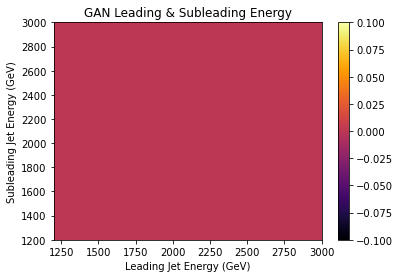

In [25]:
plt.title("GAN Leading & Subleading Energy")
plt.ylabel("Subleading Jet Energy (GeV)")
plt.xlabel("Leading Jet Energy (GeV)")
plt.hist2d(ej1, ej2, bins = 25, range = [[1200,3000],[1200,3000]], cmap = 'inferno')
plt.colorbar()
plt.show()

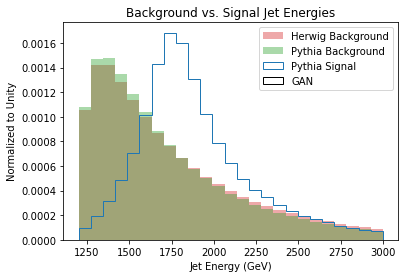

In [26]:
plt.title("Background vs. Signal Jet Energies")
plt.ylabel("Normalized to Unity")
plt.xlabel("Jet Energy (GeV)")
plt.hist(np.concatenate((df["herwig"]["ej1"], df["herwig"]["ej2"])), bins = 25, range = (1200, 3000), color = "tab:red", alpha = 0.4, label = "Herwig Background", density = True)
plt.hist(np.concatenate((df["pythiabg"]["ej1"], df["pythiabg"]["ej2"])), bins = 25, range = (1200, 3000), color = "tab:green", alpha = 0.4, label = "Pythia Background", density = True)
plt.hist(np.concatenate((df["pythiasig"]["ej1"], df["pythiasig"]["ej2"])), bins = 25, range = (1200, 3000), color = "tab:blue", histtype = "step", label = "Pythia Signal", density = True)
plt.hist(np.concatenate((ej1, ej2)), bins = 25, range = (1200, 3000), color = "black", histtype = "step", label = "GAN", density = True)
plt.legend()
plt.show()

In [27]:
for datatype in datatypes:
    df[datatype]["ejj"] = df[datatype]["ej1"] + df[datatype]["ej2"]
    df[datatype]["pjj"] = np.sqrt((df[datatype]["pxj1"] + df[datatype]["pxj2"])**2 + (df[datatype]["pyj1"] + df[datatype]["pyj2"])**2 + (df[datatype]["pyj1"] + df[datatype]["pyj2"])**2)
    df[datatype]["mjj"] = np.sqrt(df[datatype]["ejj"]**2 - df[datatype]["pjj"]**2)

In [28]:
ejj = ej1 + ej2
pjj = np.sqrt((fakedata[:,0]+fakedata[:,7])**2 + (fakedata[:,1]+fakedata[:,8])**2 + (fakedata[:,2]+fakedata[:,9])**2)
mjj = np.sqrt(ejj**2 - pjj**2)

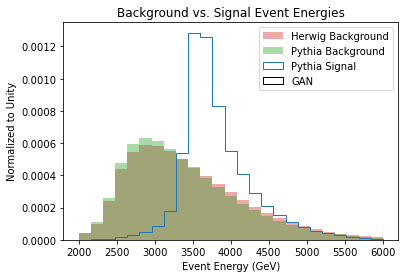

In [29]:
plt.title("Background vs. Signal Event Energies")
plt.ylabel("Normalized to Unity")
plt.xlabel("Event Energy (GeV)")
plt.hist(df["herwig"]["ejj"], bins = 25, range = (2000, 6000), color = "tab:red", alpha = 0.4, label = "Herwig Background", density = True)
plt.hist(df["pythiabg"]["ejj"], bins = 25, range = (2000, 6000), color = "tab:green", alpha = 0.4, label = "Pythia Background", density = True)
plt.hist(df["pythiasig"]["ejj"], bins = 25, range = (2000, 6000), color = "tab:blue", histtype = "step", label = "Pythia Signal", density = True)
plt.hist(ejj, bins = 25, range = (2000, 6000), color = "black", histtype = "step", label = "GAN", density = True)
plt.legend()
plt.show()

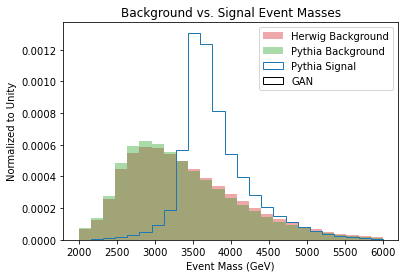

In [30]:
plt.title("Background vs. Signal Event Masses")
plt.ylabel("Normalized to Unity")
plt.xlabel("Event Mass (GeV)")
plt.hist(df["herwig"]["mjj"], bins = 25, range = (2000, 6000), color = "tab:red", alpha = 0.4, label = "Herwig Background", density = True)
plt.hist(df["pythiabg"]["mjj"], bins = 25, range = (2000, 6000), color = "tab:green", alpha = 0.4, label = "Pythia Background", density = True)
plt.hist(df["pythiasig"]["mjj"], bins = 25, range = (2000, 6000), color = "tab:blue", histtype = "step", label = "Pythia Signal", density = True)
plt.hist(mjj, bins = 25, range = (2000, 6000), color = "black", histtype = "step", label = "GAN", density = True)
plt.legend()
plt.show()

In [31]:
for datatype in datatypes:
    df[datatype]["tau21j1"] = df[datatype]["tau2j1"] / df[datatype]["tau1j1"]
    df[datatype]["tau32j1"] = df[datatype]["tau3j1"] / df[datatype]["tau2j1"]
    df[datatype]["tau21j2"] = df[datatype]["tau2j2"] / df[datatype]["tau1j2"]
    df[datatype]["tau32j2"] = df[datatype]["tau3j2"] / df[datatype]["tau2j2"]

In [32]:
tau21j1 = fakedata[:,5] / fakedata[:,4]
tau21j2 = fakedata[:,12] / fakedata[:,11]
tau32j1 = fakedata[:,6] / fakedata[:,5]
tau32j2 = fakedata[:,13] / fakedata[:,12]

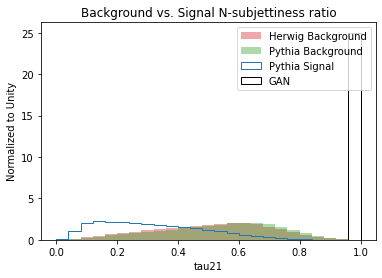

In [33]:
plt.title("Background vs. Signal N-subjettiness ratio")
plt.ylabel("Normalized to Unity")
plt.xlabel("tau21")
plt.hist(np.concatenate((df["herwig"]["tau21j1"], df["herwig"]["tau21j2"])), bins = 25, range = (0, 1), color = "tab:red", alpha = 0.4, label = "Herwig Background", density = True)
plt.hist(np.concatenate((df["pythiabg"]["tau21j1"], df["pythiabg"]["tau21j2"])), bins = 25, range = (0, 1), color = "tab:green", alpha = 0.4, label = "Pythia Background", density = True)
plt.hist(np.concatenate((df["pythiasig"]["tau21j1"], df["pythiasig"]["tau21j2"])), bins = 25, range = (0, 1), color = "tab:blue", histtype = "step", label = "Pythia Signal", density = True)
plt.hist(np.concatenate((tau21j1, tau21j2)), bins = 25, range = (0, 1), color = "black", histtype = "step", label = "GAN", density = True)
plt.legend()
plt.show()

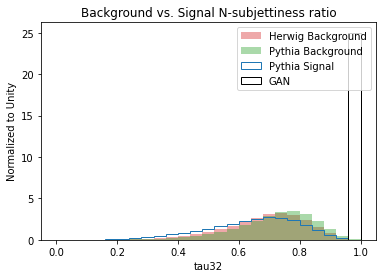

In [34]:
plt.title("Background vs. Signal N-subjettiness ratio")
plt.ylabel("Normalized to Unity")
plt.xlabel("tau32")
plt.hist(np.concatenate((df["herwig"]["tau32j1"], df["herwig"]["tau32j2"])), bins = 25, range = (0, 1), color = "tab:red", alpha = 0.4, label = "Herwig Background", density = True)
plt.hist(np.concatenate((df["pythiabg"]["tau32j1"], df["pythiabg"]["tau32j2"])), bins = 25, range = (0, 1), color = "tab:green", alpha = 0.4, label = "Pythia Background", density = True)
plt.hist(np.concatenate((df["pythiasig"]["tau32j1"], df["pythiasig"]["tau32j2"])), bins = 25, range = (0, 1), color = "tab:blue", histtype = "step", label = "Pythia Signal", density = True)
plt.hist(np.concatenate((tau32j1, tau32j2)), bins = 25, range = (0, 1), color = "black", histtype = "step", label = "GAN", density = True)
plt.legend()
plt.show()